In [1]:
!pip install opencv-contrib-python==3.4.0.12 

     |████████████████████████████████| 30.5MB 133kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [95]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [96]:
# read images
img0_name, img1_name = 'dino0001', 'dino0002'
img0 = cv2.imread(fr"{img0_name}.png", 0)
rgb0 = cv2.imread(fr"{img0_name}.png")
img1 = cv2.imread(fr"{img1_name}.png", 0)
rgb1 = cv2.imread(fr"{img1_name}.png")

In [97]:
# rotate image
img0 = cv2.rotate(img0,cv2.ROTATE_90_COUNTERCLOCKWISE)
img1 = cv2.rotate(img1,cv2.ROTATE_90_COUNTERCLOCKWISE)

In [98]:
# get matches
def get_matches(imgL, imgR, descriptor='sift'):
    if descriptor=='surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif descriptor=='sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    else:
        raise ValueError
        
    kpL, descL = descriptor.detectAndCompute(imgL, None)
    kpR, descR = descriptor.detectAndCompute(imgR, None)
    imgL_keypoints = cv2.drawKeypoints(imgL, kpL, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
    imgR_keypoints = cv2.drawKeypoints(imgR, kpR, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descL, descR, k=2) 
    
    good_matches = []
    good_matches_without_list = []
    # ratio test
    for m,n in matches:
        if m.distance < 1*n.distance: # only accept matchs that are considerably better than the 2nd best match
            good_matches.append([m])
            good_matches_without_list.append(m) # this is to simplify finding a homography later

    src_pts = np.float32([ kpL[m.queryIdx].pt for m in good_matches_without_list ])
    dst_pts = np.float32([ kpR[m.trainIdx].pt for m in good_matches_without_list ])
    return src_pts, dst_pts

In [99]:
# get correspondence points
img0_pts, img1_pts = get_matches(img0, img1)
len(img0_pts)

124

In [111]:
# Use RANSAC or LMedS to filter out points
method = cv2.RANSAC #{cv2.RANSAC or cv2.LMEDS}
M, mask = cv2.findHomography(img0_pts, img1_pts, method,5.0)
img0_pts = img0_pts[mask.ravel()==1]
img1_pts = img1_pts[mask.ravel()==1]
len(img0_pts)

74

In [112]:
# img0_pts = np.array([[77,87],
#                      [75,142],
#                      [46,55],
#                      [204,190],
#                      [154,194],
#                      [182,120],
#                      [217,171],
#                      [270,166]])

# img1_pts = np.array([[81, 83],
#                      [80,142],
#                      [47, 55],
#                      [213,191],
#                      [162, 194],
#                      [185, 121],
#                      [224, 172],
#                      [276, 169]])

In [113]:
def norm_points(img_pts):
  n = len(img_pts)
  m1, m2 = img_pts.mean(0)
  s = (img_pts - [m1, m2])**2
  s = s.mean(0)**(-0.5)
  s1, s2 = s[0], s[1]
  N = np.array([[s1, 0, -m1*s1],
                [0, s2, -m2*s2],
                [0, 0, 1]])
  
  img_pts_norm = np.empty(img_pts.shape)
  for idx, (x, y) in enumerate(img_pts):
    p_norm = N @ np.array([[x], [y], [1]])
    img_pts_norm[idx] = [p_norm[0], p_norm[1]]

  return N, img_pts_norm

In [114]:
N0, img0_pts_norm = norm_points(img0_pts)
N1, img1_pts_norm = norm_points(img1_pts)

In [115]:
def eight_points_norm(imgL_pts, imgR_pts, NL, NR):
  n = imgL_pts.shape[0]
  Q = np.empty((n, 9))
  for idx in range(n):
    pl1, pl2 = imgL_pts[idx]
    pr1, pr2 = imgR_pts[idx]
    Q[idx] = [pl1*pr1, pl2*pr1, pr1, pl1*pr2, pl2*pr2, pr2, pl1, pl2, 1]

  M = Q.T @ Q

  U,S,Vh = np.linalg.svd(M)
  idx = np.argmin(S)
  F_prime = Vh.T[:,idx].reshape(3,3)

  # rank 2 constraint
  Uf,Sf,Vhf = np.linalg.svd(F_prime)
  Sf[-1] = 0
  F_prime = Uf@(np.diag(Sf))@Vhf

  # unnormalize
  F = NL.T @ F_prime @ NR

  return F

In [116]:
F = eight_points_norm(img0_pts_norm, img1_pts_norm, N0, N1)
F

array([[ 4.75215794e-08,  4.22861835e-06,  3.12930128e-05],
       [-4.41959891e-06,  2.03508993e-07, -5.58021933e-03],
       [ 2.65111028e-05,  5.53849029e-03, -4.11653374e-03]])

In [117]:
# Test F
pl1, pl2 = img0_pts[0]
pr1, pr2 = img1_pts[0]
pl = np.array([[pl1],[pl2],[1]])
pr = np.array([[pr1],[pr2],[1]])

pr.T @ F @ pl

array([[-0.00638358]])

In [118]:
colors = []
for i in range(len(img0_pts)):
  color = tuple(np.random.randint(0,255,3).tolist())
  colors.append(color)

In [119]:
# for drawing lines when F is not calculated from the points
def drawlines_indep(img1,img2,lines,pts1,pts2,colors):
  ''' img1 - image on which we draw the epilines for the points in img2
      lines - corresponding epilines '''
  r,c = img1.shape
  img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
  img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
  i=0
  for r,pt1,pt2 in zip(lines,pts1,pts2):
    color = colors[i]
    i += 1
    # color = tuple(np.random.randint(0,255,3).tolist())
    x0,y0 = map(int, [0, -r[2]/r[1] ])
    x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
    #print(r)
    img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
    img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
    img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
  return img1,img2

In [120]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

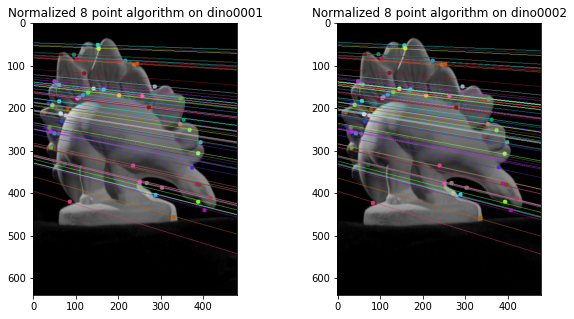

In [121]:
# epilines
# Right image
lines0 = cv2.computeCorrespondEpilines(img1_pts.reshape(-1,1,2), 2, F)
lines0 = lines0.reshape(-1,3)
img5,img6 = drawlines_indep(img0,img1,lines0,img0_pts,img1_pts, colors)
# Left image
lines1 = cv2.computeCorrespondEpilines(img0_pts.reshape(-1,1,2), 1, F)
lines1 = lines1.reshape(-1,3)
img3,img4 = drawlines_indep(img1,img0,lines1,img1_pts,img0_pts, colors)

# plot
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title(f"Normalized 8 point algorithm on {img0_name}")
plt.imshow(img5)
plt.subplot(122)
plt.title(f"Normalized 8 point algorithm on {img1_name}")
plt.imshow(img3)
plt.show()

In [122]:
# OpenCV version
# F, mask = cv2.findFundamentalMat(img0_pts,img1_pts,cv2.FM_LMEDS)
# F

In [123]:
def open_cv_homography(img0, img1, F, img0_pts, img1_pts):
  thresh = 0
  height, width = img0.shape
  _, H0, H1 = cv2.stereoRectifyUncalibrated(
      np.float32(img0_pts), np.float32(img1_pts), F, imgSize=(width, height), threshold=thresh,
  )

  img0_rectified = cv2.warpPerspective(img0, H0, (width, height))
  img1_rectified = cv2.warpPerspective(img1, H1, (width, height))
  cv2_imshow(img0_rectified)
  cv2_imshow(img1_rectified)

  return H0, H1, img0_rectified, img1_rectified

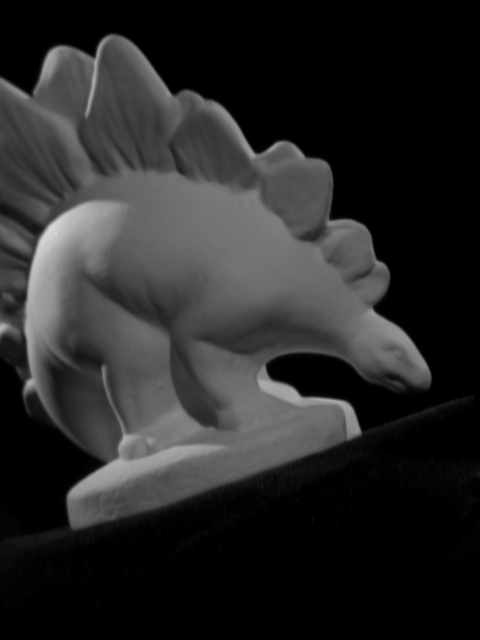

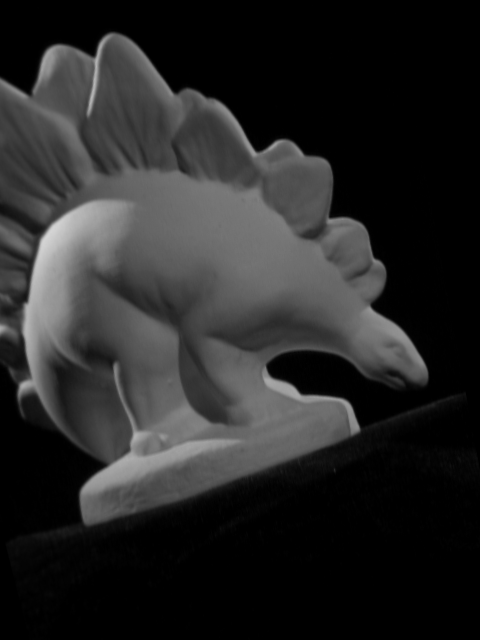

In [124]:
H0, H1, img0_rectified, img1_rectified = open_cv_homography(img0, img1, F, img0_pts, img1_pts)